## Diffusion models

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

### Kullback-Leibner Divergence

$$
    KL(q(x) || p(x)) = \mathbb{E}_{x\sim q(x)}[\log q(x) - \log p(x)]
$$

KL-divergence from scratch:  177.1358642578125
KL-divergence using pytorch: 177.1358642578125


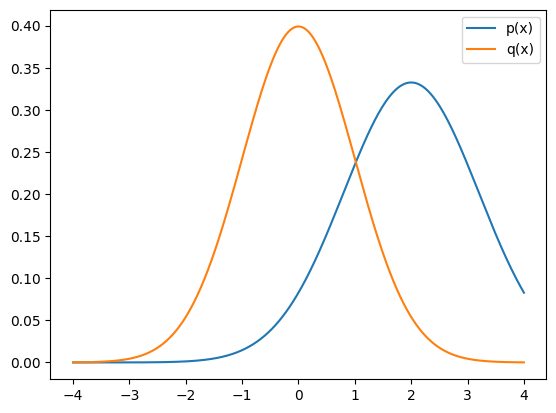

In [2]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

# define a linear range of values between -4 and 4 
x = torch.linspace(-4, 4, 1000)

# define two Gaussians with different parameters
p = gaussian(x, 2, 1.2)
q = gaussian(x, 0, 1)

plt.plot(x, p, label='p(x)')
plt.plot(x, q, label='q(x)')
plt.legend()

# kl(q || p) = sum q(x) (log q(x) - log p(x))
kl = torch.sum(q * (torch.log(q) - torch.log(p)))

# Built-in pytorch function: input is p(x) in log-space and target is q(x)
kl_torch = F.kl_div(torch.log(p), q, reduction='sum')

print(f"KL-divergence from scratch:  {kl}")
print(f"KL-divergence using pytorch: {kl_torch}")

### Simple Gaussian Mixture Model

Given 
$$
    \textbf{x}_0 \sim p_0(\textbf{x}) = \pi_1 \mathcal{N}(\textbf{x} | \mu_1, \sigma_1^2) + \pi_2 \mathcal{N}(\textbf{x} | \mu_2, \sigma_2^2)
$$
we know that
$$
    \textbf{x}_t = \sqrt{\alpha_t} \textbf{x}_{t-1} + \sqrt{(1-\alpha_t) \mathbf{\epsilon}}, \qquad \text{where } \mathbf{\epsilon} \sim \mathcal{N}(0, \textbf{I})
$$
For $t = 1, 2, \dots, T$, we can calculate the probability distribution of $\mathbf{x}_t$:
\begin{align*}
    p_t(\mathbf{x}) &= \pi_1 \mathcal{N}(\textbf{x} | \sqrt{\alpha_t} \mu_{1, t-1}, \alpha_t \sigma_{1, t-1}^2 + (1-\alpha_t))\\
    &+ \pi_2 \mathcal{N}(\textbf{x} | \sqrt{\alpha_t} \mu_{2, t-1}, \alpha_t \sigma_{2, t-1}^2 + (1-\alpha_t))
\end{align*}
gaussian = lambda x, mu, sigma: 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

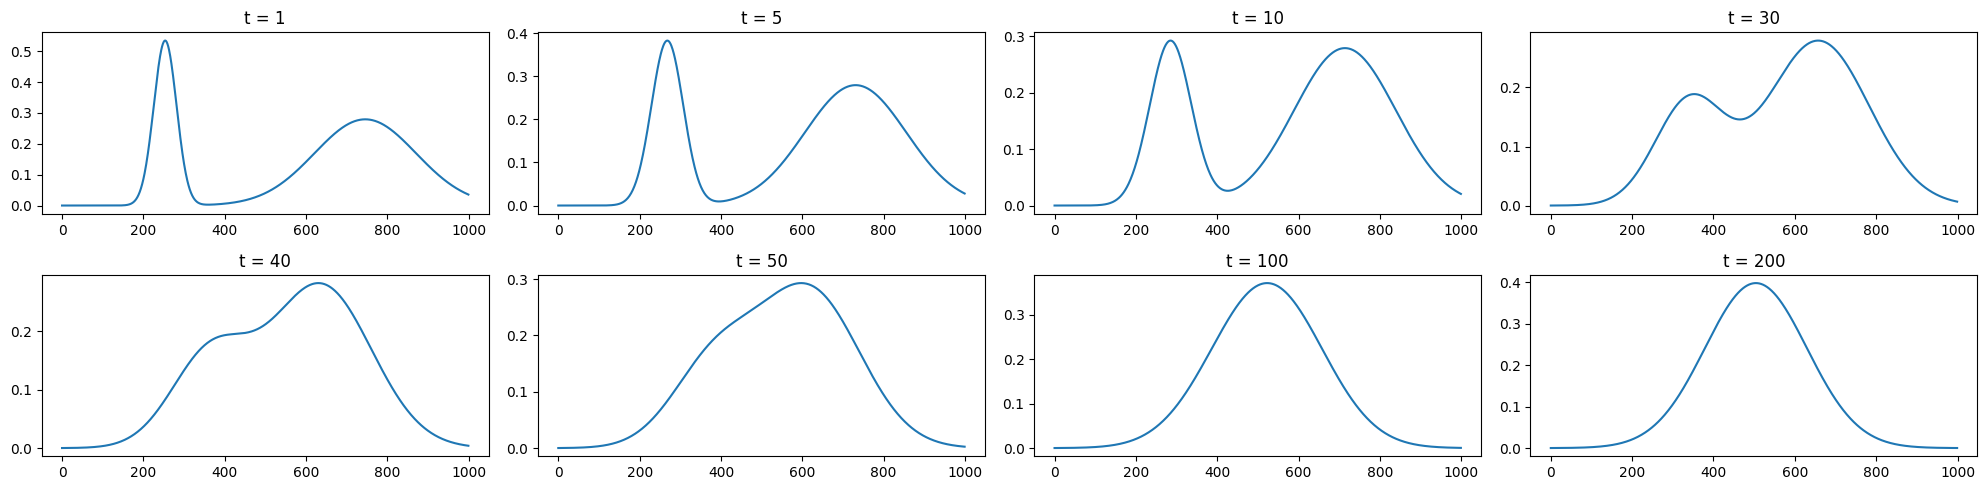

In [3]:
x = torch.linspace(-4, 4, 1000)

pi_1 = 0.3
pi_2 = 0.7

mu_1 = -2
mu_2 = 2

sigma_1 = 0.2
sigma_2 = 1

alpha_t = 0.97

ts = [1, 5, 10, 30, 40, 50, 100, 200]

fig, axes = plt.subplots(2, 4, figsize=(20, 5))
axes = axes.flatten()

for t, ax in zip(ts, axes): 

    p_t = pi_1 * gaussian(x, (alpha_t**0.5)**t * mu_1, alpha_t**t * sigma_1 + (1 - alpha_t**t)) \
        + pi_2 * gaussian(x, (alpha_t**0.5)**t * mu_2, alpha_t**t * sigma_2 + (1 - alpha_t**t))

    ax.plot(p_t)
    ax.set_title(f"t = {t}")

plt.tight_layout()
plt.show()

In [3]:
import torchvision
import torchvision.transforms as transforms

# define preprocessing transformations to dataset
transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

# load training set
train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

# load test/validation set
test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)

# split into separate test and validation sets
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv3d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv3d(128, 256, 3, padding=1)